<a href="https://colab.research.google.com/github/harsh4251/SimplyPython/blob/master/kearas-retinanet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Keras-retinanet https://github.com/fizyr/keras-retinanet

In [2]:
!nvidia-smi

Sun Jun  7 08:44:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 5758 (delta 0), reused 0 (delta 0), pack-reused 5757
Receiving objects: 100% (5758/5758), 13.37 MiB | 14.46 MiB/s, done.
Resolving deltas: 100% (3865/3865), done.


In [4]:
!pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [5]:
%cd keras-retinanet/
!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=169711 sha256=279a682f17376dffbae616471e00b193c58ad0efe1e29b53eb587a3ad78c7535
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13346 sha256=85d3b5c497c1e71aa04420764d7fd8da9b133dff48cd62e93587acebb6434603
  Stored in directory: /root/.cache/pip/wheels/80/dd/ac/842235b63dddac12faa4b48ebe58b8944e8c2e57c2e38dddb6
Successfully built keras-retinanet keras-resnet


In [6]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

In [7]:
!pip install gdown
!pip install tensorflow-gpu

     |████████████████████████████████| 516.2MB 33kB/s 


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
os.makedirs("data", exist_ok=True)

In [0]:
!unzip /content/drive/My\ Drive/AI_Developer_Task/AI_Developer_Task.zip -d /content/keras-retinanet/data/

In [0]:
!cp -rv /content/keras-retinanet/data/AI_Developer_Task/Train/* /content/keras-retinanet/data/
!cp -rv /content/keras-retinanet/data/AI_Developer_Task/Test/ /content/keras-retinanet/data/

In [0]:
#!rm -rf /content/keras-retinanet/data/Test/

Pre-processing

In [12]:
#removing descrepancy in file names
dataset='/content/keras-retinanet/data/train.txt'
df = pd.read_csv(dataset,header = None,names=["image_name", "x_min", "y_min", "x_max","y_max","class_name"])
df["image_name"]= df["image_name"].str.replace(".", "")
df["image_name"]= df["image_name"].str.replace("jpg", ".jpg")
df.head()

image_name  x_min  y_min  x_max  y_max class_name
0  A/pic_0011.jpg      2     24    176    408          A
1  A/pic_0012.jpg    132    166    240    346          A
2  A/pic_0013.jpg     61     38    418    404          A
3  A/pic_0014.jpg    144     46    467    474          A
4  A/pic_0015.jpg    124     47    417    400          A

In [13]:
#printing rows having  invalid bounding boxes
print(df[df['x_min'] > df['x_max']])
print(df[df['y_min'] > df['y_max']])
df.shape

          image_name  x_min  y_min  x_max  y_max class_name
244   A/pic_0260.jpg     97    305      4     39          A
287   A/pic_0321.jpg    428    412      1      4          A
542   A/pic_0831.jpg    284    413      2      4          A
646   B/pic_0812.jpg     83    191      3     40          B
816   C/pic_0298.jpg    201    143     77    164          C
1298  D/pic_0135.jpg    426    388     98      3          D
          image_name  x_min  y_min  x_max  y_max class_name
8     A/pic_0020.jpg    124     71    285     44          A
54    A/pic_0066.jpg    231    407    243    401          A
244   A/pic_0260.jpg     97    305      4     39          A
287   A/pic_0321.jpg    428    412      1      4          A
542   A/pic_0831.jpg    284    413      2      4          A
646   B/pic_0812.jpg     83    191      3     40          B
1298  D/pic_0135.jpg    426    388     98      3          D


(1342, 6)

In [14]:
#removing rows having  invalid bounding boxes
df.drop(df[df['x_min'] > df['x_max']].index, inplace = True)
df.drop(df[df['y_min'] > df['y_max']].index, inplace = True)
df.shape

(1334, 6)

In [15]:
#removing entries where actual files do't exists
%cd /content/keras-retinanet/data/
path = ["A/", "B/","C/","D/"]
photos_avail = []
for i in path:
  for filename in os.listdir(i):
    photos_avail.append(i+filename)
#photos_avail
#df.drop(df[df['image_name'].str not in photos_avail].index, inplace = True)
df = df[df['image_name'].isin(photos_avail)]
df.shape

/content/keras-retinanet/data


(1332, 6)

In [16]:
%cd /content/keras-retinanet/data/

/content/keras-retinanet/data


In [0]:
def show_image_objects(image_row):

  img_path = image_row.image_name
  box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
  ]

  image = read_image_bgr(img_path)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  draw_box(draw, box, color=(255, 255, 0))

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

image_name    A/pic_0757.jpg
x_min                    110
y_min                     19
x_max                    253
y_max                    281
class_name                 A
Name: 504, dtype: object


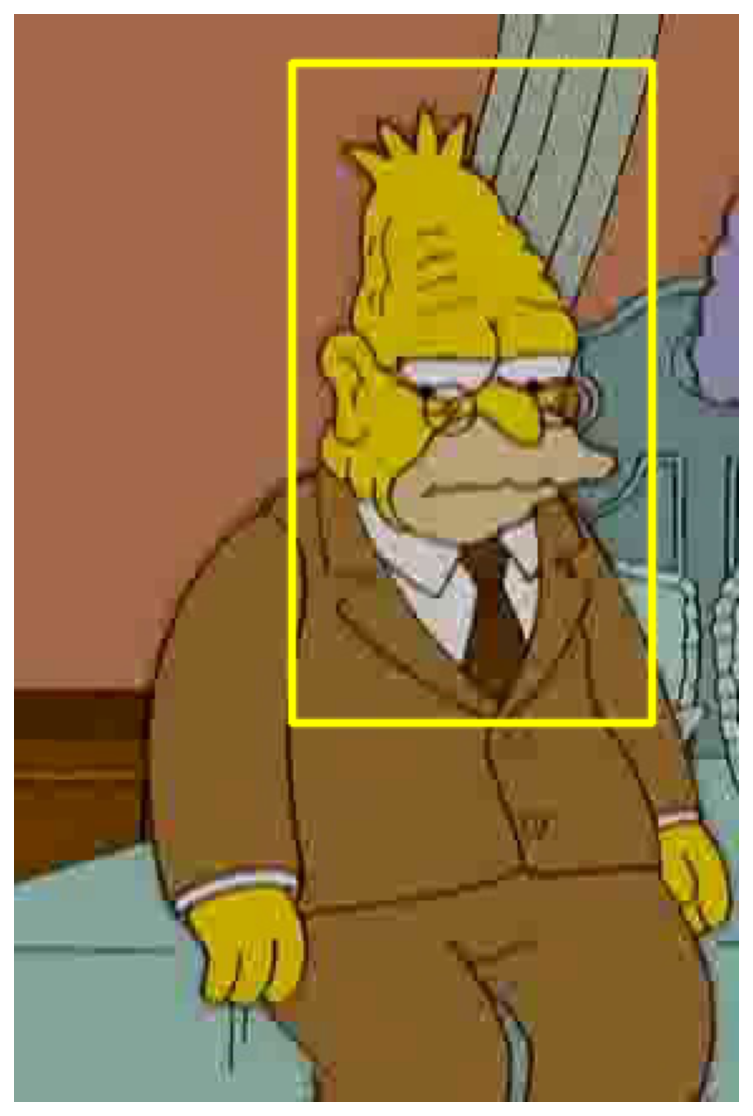

In [18]:
#!ls data/
print(df.iloc[500])
show_image_objects(df.iloc[500])

In [0]:
#splitting train-test data
train_df, test_df = train_test_split(
  df, 
  test_size=0.2, 
  random_state=RANDOM_SEED
)

In [0]:
from datetime import date
today = date.today()

d1 = today.strftime("%d_%m_%Y")
ANNOTATIONS_FILE = '/content/keras-retinanet/data/annotations.csv'
CLASSES_FILE = '/content/keras-retinanet/data/classes.csv'

ANNOTATIONS_FILE_test = '/content/keras-retinanet/data/annotations_test.csv'

today_date = d1 

In [21]:
%cd /content/keras-retinanet/

/content/keras-retinanet


In [0]:
train_df.to_csv(ANNOTATIONS_FILE, index=False, header=None)
test_df.to_csv(ANNOTATIONS_FILE_test, index=False, header=None)

In [0]:
classes = set(['A','B','C','D'])

with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(sorted(classes)):
    f.write('{},{}\n'.format(line,i))

In [24]:
!head {ANNOTATIONS_FILE}

D/pic_0082.jpg,0,20,267,402,D
B/pic_0073.jpg,33,5,170,140,B
C/pic_0718.jpg,104,115,260,331,C
A/pic_0598.jpg,109,5,358,297,A
A/pic_0188.jpg,26,38,225,288,A
A/pic_0298.jpg,62,142,158,252,A
C/pic_0262.jpg,80,100,227,338,C
A/pic_0227.jpg,170,24,497,464,A
A/pic_0440.jpg,2,4,121,306,A
A/pic_0157.jpg,155,14,457,457,A


In [25]:
!head {CLASSES_FILE}

A,0
B,1
C,2
D,3


In [0]:
#PRETRAINED_MODEL = '/content/drive/My\ Drive/retinanet_snapshots/06_06_2020/resnet50_csv_10.h5'

In [0]:
#PRETRAINED_MODEL20 = '/content/drive/My\ Drive/retinanet_snapshots/06_06_2020_20_epoc/resnet50_csv_20.h5'

In [28]:
PRETRAINED_MODEL = '/content/keras-retinanet/snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to /content/keras-retinanet/snapshots/_pretrained_model.h5


In [29]:
%cd /content/keras-retinanet/data/

/content/keras-retinanet/data


Checking train file size for calculating 

step-size = training-filesize/batch-size -> 1065/10 ~ 106

In [30]:
!wc -l {ANNOTATIONS_FILE}

1065 /content/keras-retinanet/data/annotations.csv


training

```
# !/content/keras-retinanet/keras_retinanet/bin/train.py --snapshot-path /content/drive/My\ Drive/retinanet_snapshots/{today_date}/ --freeze-backbone --compute-val-loss --random-transform --tensorboard-dir /content/drive/My\ Drive/retinanet_snapshots_tensorboard_logs/ --weights {PRETRAINED_MODEL} --batch-size 8 --steps 133 --epochs 20 csv annotations.csv classes.csv
```



In [31]:
!/content/keras-retinanet/keras_retinanet/bin/train.py \
--snapshot-path /content/drive/My\ Drive/retinanet_snapshots/{today_date}/ \
--freeze-backbone --compute-val-loss --random-transform \
--tensorboard-dir /content/drive/My\ Drive/retinanet_snapshots_tensorboard_logs/{today_date}/ \
--weights {PRETRAINED_MODEL} \
--batch-size 10 \
--steps 106 \
--epochs 25 \
csv annotations.csv classes.csv

Using TensorFlow backend.
Creating model, this may take a second...
2020-06-07 08:47:06.701068: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-07 08:47:06.778725: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-06-07 08:47:06.779723: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-06-07 08:47:06.780074: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-06-07 08:47:07.053034: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-06

Converting model for evaluation

In [49]:
!/content/keras-retinanet/keras_retinanet/bin/convert_model.py '/content/drive/My Drive/retinanet_snapshots/07_06_2020/resnet50_csv_20.h5' /content/model.h5

Using TensorFlow backend.
2020-06-07 10:05:07.294376: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-07 10:05:07.298815: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-06-07 10:05:07.299268: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-06-07 10:05:07.299516: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-06-07 10:05:07.301203: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-06-07 10:05:07.302841: I tensorflow/stream_e

Checking losses in tensorboard

In [0]:
%load_ext tensorboard

In [34]:
%tensorboard --logdir %tensorboard --logdir /content/drive/My\ Drive/retinanet_snapshots_tensorboard_logs/07_06_2020/

<IPython.core.display.Javascript object>

In [0]:
#!/content/keras-retinanet/keras_retinanet/bin/convert_model.py {PRETRAINED_MODEL20} /content/model20.h5

Evaluating model

In [50]:
!/content/keras-retinanet/keras_retinanet/bin/evaluate.py csv {ANNOTATIONS_FILE_test} {CLASSES_FILE} /content/model.h5

Using TensorFlow backend.
Loading model, this may take a second...
2020-06-07 10:05:31.137140: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-07 10:05:31.141899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-06-07 10:05:31.142353: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-06-07 10:05:31.142584: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-06-07 10:05:31.144023: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-06-

Loading trained model for prediction

In [59]:
#model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
model_path = '/content/drive/My Drive/retinanet_snapshots/07_06_2020/resnet50_csv_20.h5'
print(model_path)

model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

labels_to_names = pd.read_csv(CLASSES_FILE, header=None).T.loc[0].to_dict()

/content/drive/My Drive/retinanet_snapshots/07_06_2020/resnet50_csv_20.h5
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, 

In [0]:
def predict(image):
  image = preprocess_image(image.copy())
  image, scale = resize_image(image)

  boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(image, axis=0)
  )

  boxes /= scale

  return boxes, scores, labels

Keeping only maximum score prediction

In [0]:
#THRES_SCORE = 0.35

def draw_detections(image, boxes, scores, labels):
  #for box, score, label in zip(boxes[0], scores[0], labels[0]):
    #if score < THRES_SCORE:
        #break
    
    r = zip(boxes[0], scores[0], labels[0])
    z = [list(c) for c in r]

    #use the tuple() function to display a readable version of the result:
    y = sorted(z, key=lambda x: x[1],reverse=True)
    #print(y)
    #print(y[0][0])
    
    #taking maximum score as prediction out of all
    box, score, label =  y[0][0],y[0][1],y[0][2]
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(image, b, color=color)

    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(image, b, caption)

In [0]:
def show_detected_objects(image_row):
  img_path = image_row.image_name
  
  image = read_image_bgr(img_path)

  boxes, scores, labels = predict(image)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  true_box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
  ]
  draw_box(draw, true_box, color=(255, 255, 0))

  draw_detections(draw, boxes, scores, labels)

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

In [0]:
def save_detected_objects_in_image(img_path):
  
  image = read_image_bgr(img_path)

  boxes, scores, labels = predict(image)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  draw_detections(draw, boxes, scores, labels)

  plt.axis('off')
  plt.imshow(draw)
  fdir = os.path.dirname(img_path)
  fname = os.path.basename(img_path)
  print('saving files to {}'.format(fdir+'/pred_'+fname))
  plt.savefig(fdir+'/pred_'+fname,bbox_inches='tight')
  plt.close()
  #plt.show()

In [43]:
test_df.head(n=10)

image_name  x_min  y_min  x_max  y_max class_name
1289  D/pic_0124.jpg     36     22    223    296          D
1069  C/pic_0951.jpg    117    161    494    271          C
1259  D/pic_0148.jpg     99     37    218    273          D
302   A/pic_0349.jpg    246     20    405    333          A
239   A/pic_0255.jpg    181     43    506    456          A
594   B/pic_0113.jpg     25      6    113    103          B
242   A/pic_0258.jpg     30     20    253    321          A
280   A/pic_0301.jpg    146     50    393    399          A
895   C/pic_0510.jpg    168    210    286    392          C
711   C/pic_0069.jpg     87     16    393    404          C

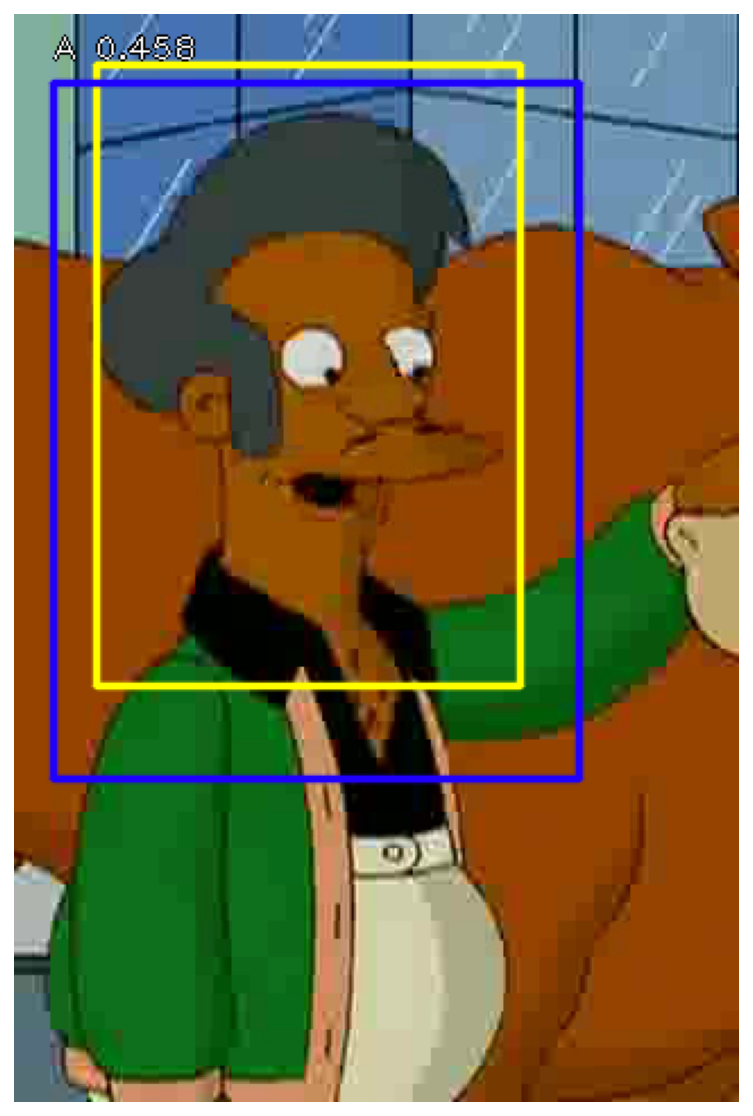

In [44]:
show_detected_objects(test_df.iloc[0])

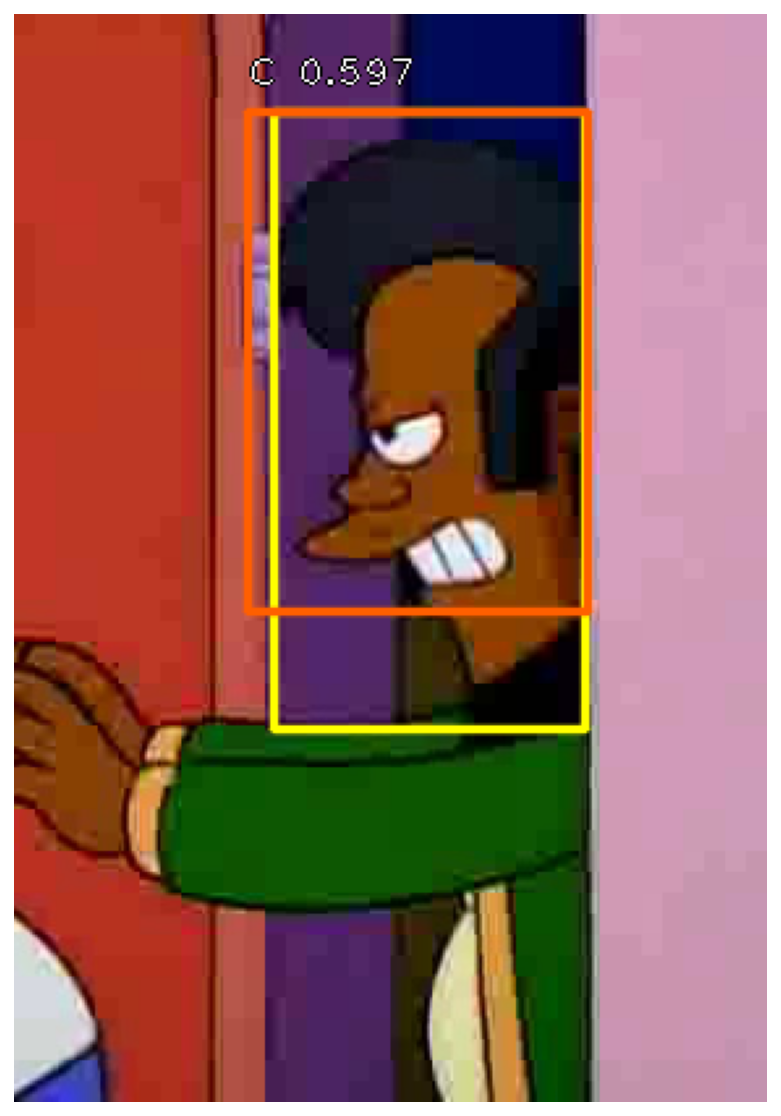

In [45]:
show_detected_objects(test_df.iloc[2])

In [63]:
#save_detected_objects_in_image('/content/keras-retinanet/data/Test/t1/pic_0001.jpg')
#os.path.dirname('/content/keras-retinanet/data/Test/t1/pic_0003.jpg')
#os.path.basename('/content/keras-retinanet/data/Test/t1/pic_0003.jpg')
#!pwd
#os.listdir('/content/keras-retinanet/data/Test/t1/')

saving files to /content/keras-retinanet/data/Test/t1/pred_pic_0001.jpg


In [0]:
folders = ["t1", "t2","t3","t4"]
path = '/content/keras-retinanet/data/Test'
for i in folders:
  full_path = os.path.join(path,i)
  for filename in os.listdir(full_path):
    if not filename.startswith('.'):
      print(os.path.join(full_path,filename))
      save_detected_objects_in_image(os.path.join(full_path,filename))

Saving predicted images into drive

In [0]:
!cp -rv /content/keras-retinanet/data/Test/ /content/drive/My\ Drive/retinanet_snapshots/